<a href="https://colab.research.google.com/github/spaceml-org/Self-Supervised-Learner/blob/simsiam/tutorials/PythonColabTutorial_Merced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Using SSL-Curator Repo
In this tutorial you'll see: 
- The commands to train an SSL model
-Load the SSL model, to run your own custom inference script
-Load the SSL model, to run your own dataset for inference with the DALI pipeline
-The command to train a finetuner model based on your previously trained SSL Model
-Running custom and DALI inference on the trained model



In [4]:
#installs
!pip install -q split-folders
!pip install -q pytorch-lightning==1.1.8
!pip install -q pytorch-lightning-bolts
!pip install -q --extra-index-url https://developer.download.nvidia.com/compute/redist nvidia-dali-cuda100
!pip install -q wandb

#download data
!gdown http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
!unzip -qq UCMerced_LandUse.zip

     |████████████████████████████████| 696kB 24.1MB/s 
     |████████████████████████████████| 276kB 53.8MB/s 
     |████████████████████████████████| 829kB 43.3MB/s 
     |████████████████████████████████| 112kB 49.0MB/s 
     |████████████████████████████████| 1.3MB 45.8MB/s 
     |████████████████████████████████| 143kB 55.0MB/s 
     |████████████████████████████████| 296kB 51.7MB/s 
     |████████████████████████████████| 256kB 22.4MB/s 
     |████████████████████████████████| 389.9MB 45kB/s 
     |████████████████████████████████| 2.0MB 18.0MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 133kB 54.6MB/s 
     |████████████████████████████████| 163kB 56.4MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
Downloading...
From: http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip
To: /content/UCMerced_LandUse.zip
100% 332M/332M [00:12<00:00, 26.4MB/s]


In [1]:
import os
import itertools
import shutil
import PIL
import matplotlib.pyplot as plt
import torch
from torch import nn
from tqdm.notebook import tqdm
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import numpy as np
import PIL.Image as Image
import time
#not logging on wandb in this demo
os.environ['WANDB_MODE']='disabled'

In [2]:
!rm -rf SSL
!git clone --branch simsiam https://github.com/spaceml-org/Self-Supervised-Learner.git
!mv Self-Supervised-Learner SSL

Cloning into 'Self-Supervised-Learner'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 2531 (delta 0), reused 0 (delta 0), pack-reused 2527
Receiving objects: 100% (2531/2531), 11.75 MiB | 43.30 MiB/s, done.
Resolving deltas: 100% (1590/1590), done.


# Training Self-Supervised Learning Model

In [5]:
!python SSL/train.py --technique SIMCLR --DATA_PATH /content/UCMerced_LandUse/Images --model minicnn32 --log_name ssl --epochs 5 --batch_size 32 --image_size 256

Automatically splitting data into train and validation data...
Copying files: 2100 files [00:04, 447.10 files/s]
Model architecture successfully loaded
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
read 1680 files from 21 directories
read 420 files from 21 directories

  | Name       | Type       | Params
------------------------------------------
0 | projection | Projection | 20.9 K
1 | encoder    | miniCNN    | 128 K 
------------------------------------------
149 K     Trainable params
0         Non-trainable params
149 K     Total params
Validation sanity check:   0% 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/step_result.py:145: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  value = torch.tensor(value, device=device, dtype=torch

# Fine Tuning Model

In [7]:
!python SSL/train.py --technique CLASSIFIER --DATA_PATH /content/UCMerced_LandUse/Images --model ./models/SIMCLR_ssl.ckpt --log_name ft --epochs 20 --batch_size 32 --image_size 256

Automatically splitting data into train and validation data...
Copying files: 2100 files [00:01, 2040.64 files/s]
Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100% 44.7M/44.7M [00:00<00:00, 53.0MB/s]
Model architecture successfully loaded
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
read 1680 files from 21 directories
read 420 files from 21 directories

  | Name         | Type         | Params
----------------------------------------------
0 | linear_layer | SSLEvaluator | 68.5 K
1 | train_acc    | Accuracy     | 0     
2 | val_acc      | Accuracy     | 0     
3 | encoder      | ResNet       | 11.7 M
----------------------------------------------
11.8 M    Trainable params
0         Non-trainable params
11.8 M    Total params
Validation sanity check:   0% 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/pytorch_lightning/

# Loading Trained Models in Python

In [ ]:
#load model for custom inference script below
%cd /content/SSL
from models import SIMCLR, CLASSIFIER
%cd /content/

/content/SSL
/content


In [ ]:
simclr_model = SIMCLR.SIMCLR.load_from_checkpoint('/content/models/SIMCLR_ssl.ckpt')
classifier_model = CLASSIFIER.CLASSIFIER.load_from_checkpoint('/content/models/CLASSIFIER_ft.ckpt')

simclr_model.eval()
classifier_model.eval()

simclr_model.cuda()   
classifier_model.cuda()   

CLASSIFIER(
  (linear_layer): SSLEvaluator(
    (block_forward): Sequential(
      (0): Flatten()
      (1): Dropout(p=0.1, inplace=False)
      (2): Linear(in_features=32, out_features=128, bias=False)
      (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=128, out_features=21, bias=True)
    )
  )
  (train_acc): Accuracy()
  (val_acc): Accuracy()
  (encoder): miniCNN(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (adaptive_pool): AdaptiveAvgPool2d(output_size=(16, 16))
    (conv4): Conv2d(48, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (flatten): Flatten(sta

To run inference, we need to transform an image from a 244x244x3 image (the shape of UC Merced Data) to a 3x256x256 image, which is what we trained our model on.

Category is:  tensor([0], device='cuda:0')


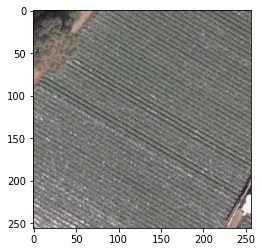

In [ ]:
#How to run inference manually

import numpy as np
from PIL import Image
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

f = "/content/UCMerced_LandUse/Images/agricultural/agricultural00.tif" #insert image here

im = Image.open(f).convert('RGB')
plt.imshow(im)

def to_tensor(pil):
    return torch.tensor(np.array(pil)).permute(2,0,1).float()

t = transforms.Compose([
                        transforms.Resize((256,256)),
                        transforms.Lambda(to_tensor)
                        ])

datapoint = t(im).unsqueeze(0).cuda() #only a single datapoint so we unsqueeze to add a dimension

with torch.no_grad():
  embedding = simclr_model(datapoint) #get embedding
  category = classifier_model(datapoint) #get classification
  print('Category is: ',  torch.argmax(category, 1)) 

Or below, if you don't want to write the transforms yourself, we will use the built in DALI pipeline to do inference quickly on a large number of datapoints

In [ ]:
#We'll pretend the agriculture images are a new dataset we want to run inference on after training on UC Merced Data previously
!rm -rf /content/new_images_to_run_inference
!mkdir /content/new_images_to_run_inference
!cp -r /content/UCMerced_LandUse/Images/agricultural /content/new_images_to_run_inference

In [ ]:
model = CLASSIFIER.CLASSIFIER.load_from_checkpoint('/content/models/CLASSIFIER_ft.ckpt', DATA_PATH  = '/content/new_images_to_run_inference', batch_size = 196) #specify new datapath

In [ ]:
model.local_rank = 0
model.setup() #we set up inference with this call to instantiate the DALI data pipeline
model.eval()
model.cuda()

for batch in model.inference_dataloader:
    predictions = model(batch)
    print(predictions.shape) #dimensions of predictions are batch_size * num_classes
    break

torch.Size([196, 21])


In [ ]:
#This inference pipeline scales quite nicely to large datasets
num_datapoints = 100000
batch_size = 196

start = time.time()

for i in range(num_datapoints//batch_size):
  data = next(model.inference_dataloader)
  batch_predictions = model(data)

print('Time Taken: ', time.time()-start)

Time Taken:  33.406495332717896
